In [1]:
import tensorflow as tf
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
sess = tf.Session()

c:\users\sdpl\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
xy = np.loadtxt('pipedata.csv', delimiter=',', dtype=np.float32)
x_vals = xy[:, 0:-1]
y_vals = np.array([x[7] for x in xy])

In [3]:
batch_size = 100

In [4]:
train_indices = np.random.choice(len(x_vals),round(len(x_vals)*0.824), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [5]:
def init_weight(n_inputs, n_outputs, uniform=True):
    if uniform:
        init_range = math.sqrt(6.0 / ((n_inputs/2) + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        stddev = math.sqrt(3.0 / ((n_inputs/2) + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

In [6]:
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [7]:
def fully_connected(input_layer, weights, biases) :
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))

In [8]:
weight_11 = tf.get_variable("Weight_11", shape=[7, 128], initializer=init_weight(7, 128))
bias_11 = tf.Variable(tf.random_normal([128]))
layer_11 = fully_connected(x_data, weight_11, bias_11)

In [9]:
weight_1 = tf.get_variable("Weight_1", shape=[128, 64], initializer=init_weight(128, 64))
bias_1 = tf.Variable(tf.random_normal([64]))
layer_1 = fully_connected(layer_11, weight_1, bias_1)

In [10]:
weight_2 = tf.get_variable("Weight_2", shape=[64, 32], initializer=init_weight(64, 32))
bias_2 = tf.Variable(tf.random_normal([32]))
layer_2 = fully_connected(layer_1, weight_2, bias_2)

In [11]:
weight_3 = tf.get_variable("Weight_3", shape=[32, 16], initializer=init_weight(32, 16))
bias_3 = tf.Variable(tf.random_normal([16]))
layer_3 = fully_connected(layer_2, weight_3, bias_3)

In [12]:
weight_4 = tf.get_variable("Weight_4", shape=[16, 8], initializer=init_weight(16, 8))
bias_4 = tf.Variable(tf.random_normal([8]))
layer_4 = fully_connected(layer_3, weight_4, bias_4)

In [13]:
weight_5 = tf.get_variable("Weight_5", shape=[8, 4], initializer=init_weight(8, 4))
bias_5 = tf.Variable(tf.random_normal([4]))
layer_5 = fully_connected(layer_4, weight_5, bias_5)

In [14]:
weight_6 = tf.get_variable("Weight_6", shape=[4, 2], initializer=init_weight(4, 2))
bias_6 = tf.Variable(tf.random_normal([2]))
layer_6 = fully_connected(layer_5, weight_6, bias_6)

In [15]:
weight_7 = tf.get_variable("Weight_7", shape=[2, 1], initializer=init_weight(2, 1))
bias_7 = tf.Variable(tf.random_normal([1]))
final_output = fully_connected(layer_6, weight_7, bias_7)

In [16]:
predictions_correct = tf.abs(((final_output-y_target)/y_target)*100)
accuracy = tf.reduce_mean(predictions_correct)

In [17]:
loss = tf.reduce_mean(tf.abs(y_target - final_output))
my_opt = tf.train.AdamOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
loss_vec = []
test_loss = []
acc_vec = []
test_acc = []
for i in range(10000):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target : rand_y})
    loss_vec.append(temp_loss)
    test_temp_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    temp_acc = sess.run(accuracy, feed_dict={x_data: rand_x, y_target : rand_y})
    acc_vec.append(temp_acc)
    test_temp_acc = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(test_temp_acc)

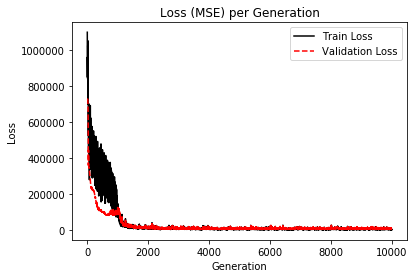

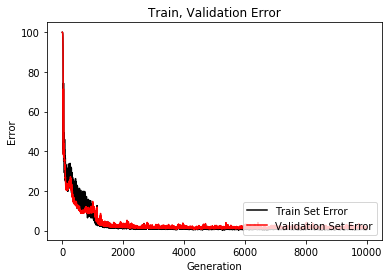

In [19]:
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Validation Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

plt.plot(acc_vec, 'k-', label='Train Set Error')
plt.plot(test_acc, 'r-', label='Validation Set Error')
plt.title('Train, Validation Error')
plt.xlabel('Generation')
plt.ylabel('Error')
plt.legend(loc='lower right')
plt.show()

In [20]:
y_train = sess.run(final_output, feed_dict = {x_data: rand_x, y_target : rand_y})
e_train = sess.run(predictions_correct, feed_dict = {x_data: rand_x, y_target : rand_y})
y_valid = sess.run(final_output, feed_dict = {x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
e_valid = sess.run(predictions_correct, feed_dict = {x_data: x_vals_test, y_target: np.transpose([y_vals_test])})

In [21]:
np.savetxt("./pipe-full/result(7)(train).csv", (e_train), delimiter=',')
np.savetxt("./pipe-full/result(7)(valid).csv", (e_valid), delimiter=',')

In [22]:
xy = np.loadtxt('pipedata(test).csv', delimiter=',', dtype=np.float32)
x_vals = xy[:, 0:-1]
y_vals = np.array([x[7] for x in xy])

In [23]:
test_indices = np.array(list(set(range(len(x_vals)))))
x_vals_test = x_vals[test_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [24]:
y_test = sess.run(final_output, feed_dict = {x_data: x_vals_test})
e_test = sess.run(predictions_correct, feed_dict = {x_data: x_vals_test, y_target: np.transpose([y_vals_test])})

In [25]:
np.savetxt("./pipe-full/result(7)(test.y).csv", (y_test), delimiter=',')
np.savetxt("./pipe-full/result(7)(test).csv", (e_test), delimiter=',')